Chapter 16

# 正交回归，多元
Book_7《机器学习》 | 鸢尾花书：从加减乘除到机器学习

In [1]:
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [2]:
p = plt.rcParams
p["font.sans-serif"] = ["Roboto"]
p["font.weight"] = "light"
p["ytick.minor.visible"] = True
p["xtick.minor.visible"] = True
p["axes.grid"] = True
p["grid.color"] = "0.5"
p["grid.linewidth"] = 0.5


In [3]:
tickers = ['TSLA','WMT','MCD','USB',
           'YUM','NFLX','JPM','PFE',
           'F','GM','COST','JNJ', '^GSPC'];

stock_levels_df = yf.download(tickers, start='2020-01-01', end='2020-12-31')

[*********************100%%**********************]  13 of 13 completed


In [4]:
stock_levels_df.to_csv('stock_levels_df.csv')
stock_levels_df.to_pickle('stock_levels_df.pkl')

In [5]:
X_y_df = stock_levels_df['Adj Close'].pct_change()
X_y_df.dropna(inplace = True)

X_y_df.rename(columns={"^GSPC": "SP500"},inplace = True)
X_df = X_y_df.iloc[:,:-1]
y_df = X_y_df[['SP500']]

In [6]:
#%% TLS, matrix computation

SIMGA = X_y_df.cov()

Lambda, V = np.linalg.eig(SIMGA)

idx = Lambda.argsort()[::-1]   
Lambda = Lambda[idx]
V = V[:,idx]

lambda_min = np.min(Lambda)

D = len(tickers[:-1])

b_TLS_ = -V[0:D,D]/V[D,D]

print(b_TLS_)

[ 0.25908786  0.01824322  0.0373678   0.25978646  0.15377967  0.17647761
  0.11275032  0.04741226  0.02438509  0.04140727 -0.03435162  0.01765148]


In [7]:
b0_TLS_ = y_df.mean().values - b_TLS_@X_df.mean().values
print(b0_TLS_)

[-0.00039445]


In [8]:
b_TLS = np.hstack((b0_TLS_,b_TLS_))

labels = ['const'] + tickers[:-1]
b_df_TLS = pd.DataFrame(data=b_TLS.T, index=[labels], columns=['TLS']) 

In [9]:
#%% OLS Regression
import statsmodels.api as sm

# add a column of ones
X_df = sm.add_constant(X_df)

model = sm.OLS(y_df, X_df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  SP500   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     301.8
Date:                Tue, 21 Nov 2023   Prob (F-statistic):          1.71e-136
Time:                        20:18:41   Log-Likelihood:                 954.64
No. Observations:                 251   AIC:                            -1883.
Df Residuals:                     238   BIC:                            -1837.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.000     -1.111      0.2

In [10]:
b_df_OLS = model.fit().params
print(b_df_OLS)

const   -0.000396
COST     0.213459
F        0.017301
GM       0.042511
JNJ      0.219896
JPM      0.133239
MCD      0.157656
NFLX     0.113743
PFE      0.066497
TSLA     0.026612
USB      0.058301
WMT      0.013201
YUM      0.040400
dtype: float64


In [11]:
b_df_OLS = pd.DataFrame(data=b_df_OLS.values, index=[labels], columns=['OLS']) 


coeffs = pd.concat([b_df_TLS, b_df_OLS], axis=1, join="inner")

In [12]:
coeffs

,TLS,OLS
const,-0.000394,-0.000396
TSLA,0.259088,0.213459
WMT,0.018243,0.017301
MCD,0.037368,0.042511
USB,0.259786,0.219896
YUM,0.153780,0.133239
NFLX,0.176478,0.157656
JPM,0.112750,0.113743
PFE,0.047412,0.066497
F,0.024385,0.026612


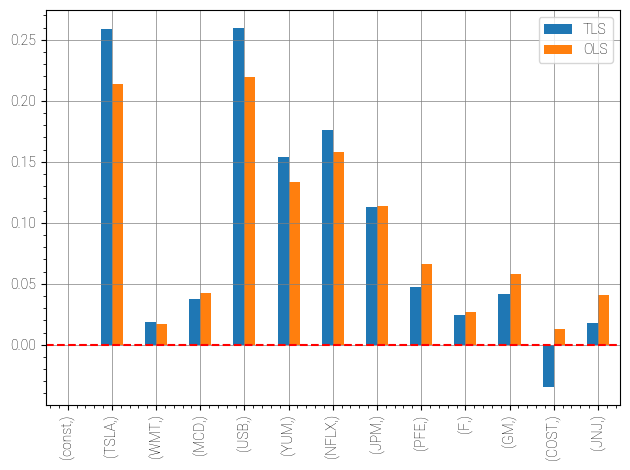

In [13]:
fig, ax = plt.subplots()
coeffs.plot.bar(ax = ax)
# h.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.axhline(y=0, color='r', linestyle='--')